In [1]:
import os
from pathlib import Path
import numpy as np
import cv2
%pylab inline

import lib.orientation as orient
import lib.coordinates as coord
from lib.camera import img_from_device, denormalize, view_frame_from_device_frame

Populating the interactive namespace from numpy and matplotlib


In [5]:
example_segment = Path("/media/watouser/Seagate_Backup/datasets/comma2k19/Chunk_3/99c94dc769b5d96e|2018-05-05--11-09-01/12")

/home/methier/end-to-end-driving/lib/camera.py:86: RuntimeWarning: invalid value encountered in greater
  img_pts_denormalized[img_pts_denormalized[:,1] > H] = np.nan
/home/methier/end-to-end-driving/lib/camera.py:87: RuntimeWarning: invalid value encountered in less
  img_pts_denormalized[img_pts_denormalized[:,1] < 0] = np.nan
/home/methier/end-to-end-driving/lib/camera.py:85: RuntimeWarning: invalid value encountered in less
  img_pts_denormalized[img_pts_denormalized[:,0] < 0] = np.nan
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Driven path projected onto first image')

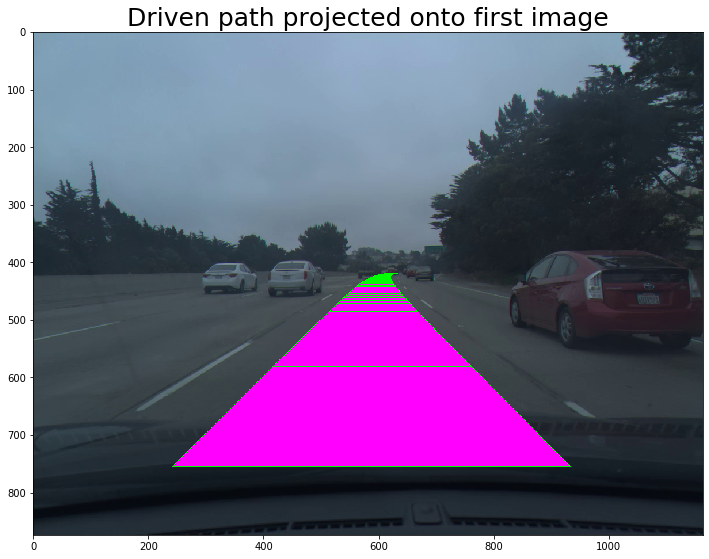

In [6]:
# We can project the path driven onto the first image
frame_times = np.load(example_segment / 'global_pose/frame_times')
frame_positions = np.load(example_segment / 'global_pose/frame_positions')
frame_orientations = np.load(example_segment / 'global_pose/frame_orientations')

# first we convert the frame_positions to the frame
# defined by the pose of the first frame
ecef_from_local = orient.rot_from_quat(frame_orientations[0])
local_from_ecef = ecef_from_local.T
frame_positions_local = np.einsum('ij,kj->ki', local_from_ecef, frame_positions - frame_positions[0])


from lib.camera import img_from_device, denormalize, view_frame_from_device_frame
def draw_path(device_path, img, width=1, height=1, fill_color=(128,0,255), line_color=(0,255,0)):
    device_path_l = device_path + np.array([0, 0, height])                                                                    
    device_path_r = device_path + np.array([0, 0, height])                                                                    
    device_path_l[:,1] -= width                                                                                               
    device_path_r[:,1] += width

    img_points_norm_l = img_from_device(device_path_l)
    img_points_norm_r = img_from_device(device_path_r)
    img_pts_l = denormalize(img_points_norm_l)
    img_pts_r = denormalize(img_points_norm_r)

    # filter out things rejected along the way
    valid = np.logical_and(np.isfinite(img_pts_l).all(axis=1), np.isfinite(img_pts_r).all(axis=1))
    img_pts_l = img_pts_l[valid].astype(int)
    img_pts_r = img_pts_r[valid].astype(int)

    for i in range(1, len(img_pts_l)):
        u1,v1,u2,v2 = np.append(img_pts_l[i-1], img_pts_r[i-1])
        u3,v3,u4,v4 = np.append(img_pts_l[i], img_pts_r[i])
        pts = np.array([[u1,v1],[u2,v2],[u4,v4],[u3,v3]], np.int32).reshape((-1,1,2))
        cv2.fillPoly(img,[pts],fill_color)
        cv2.polylines(img,[pts],True,line_color)

img = imread(str(example_segment / 'preview.png'))
draw_path(frame_positions_local[1:101], img) # show next 5 seconds (100 frames)
figsize(12,12);
imshow(img)
title('Driven path projected onto first image', fontsize=25)

In [7]:
frame_positions_local[0:201] # (n, 3) where col 0 is x, col 1 is y, col 2 is z

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.31603485e+00,  8.41989308e-03, -4.06417522e-02],
       [ 2.63265307e+00,  1.79573186e-02, -8.13818546e-02],
       [ 3.94694805e+00,  2.89779373e-02, -1.21938900e-01],
       [ 5.26289086e+00,  4.17516320e-02, -1.62270694e-01],
       [ 6.57753351e+00,  5.58037363e-02, -2.02489661e-01],
       [ 7.89309645e+00,  7.10305902e-02, -2.42974319e-01],
       [ 9.20866394e+00,  8.71150723e-02, -2.83763866e-01],
       [ 1.05246901e+01,  1.03760107e-01, -3.24787259e-01],
       [ 1.18408830e+01,  1.22022175e-01, -3.66510441e-01],
       [ 1.31563772e+01,  1.41245287e-01, -4.09070804e-01],
       [ 1.44723788e+01,  1.61723662e-01, -4.52273221e-01],
       [ 1.57902086e+01,  1.83738687e-01, -4.95651219e-01],
       [ 1.71051426e+01,  2.06693263e-01, -5.38603159e-01],
       [ 1.84208709e+01,  2.30760741e-01, -5.81181977e-01],
       [ 1.97366228e+01,  2.56164414e-01, -6.23714943e-01],
       [ 2.10514693e+01,  2.82345936e-01

In [8]:
frame_times.shape

(1200,)

In [9]:
frame_times

array([826.499643, 826.549659, 826.599692, ..., 886.348804, 886.398825,
       886.448799])

In [10]:
frame_len = (frame_times[-1] - frame_times[0])/frame_times.shape[0]
5/frame_len

100.08481186957825

In [11]:
# Opening frames from the hevc
video_path = example_segment / "video.hevc"
frame_count = 0
cap = cv2.VideoCapture(str(video_path))
while cap.isOpened():
    ret, frame = cap.read()
    if ret:
#         # Zero pad frame_count and save frame
#         img_path = img_dir / (str(frame_count).zfill(6) + '.jpg')
#         cv2.imwrite(str(img_path), frame)
        frame_count += 1
    else:
        break
cap.release()
print(frame_count)

1200
